In [1]:
# python libraries
import time
import builtins
import sys
import numpy as np
import pydot
import matplotlib.pyplot as plt
from IPython.display import HTML, display, SVG

# pydrake imports
from pydrake.all import (
    AddMultibodyPlantSceneGraph, DiagramBuilder, Linearize, 
    LinearQuadraticRegulator, LogVectorOutput,
    MeshcatVisualizer, ModelVisualizer, Parser, Simulator, 
    StartMeshcat, LeafSystem, MultibodyPlant, VectorSystem, PiecewisePolynomial, 
    MathematicalProgram, Solve, SnoptSolver, DirectCollocation, 
    MakeFiniteHorizonLinearQuadraticRegulator,
    FiniteHorizonLinearQuadraticRegulator, 
    FiniteHorizonLinearQuadraticRegulatorOptions,
)

from pydrake.autodiffutils import AutoDiffXd
from pydrake.geometry import SceneGraph, CollisionFilterDeclaration
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.systems.framework import LeafSystem_
from pydrake.symbolic import if_then_else, arctan2, Jacobian
from pydrake.solvers import GurobiSolver, SnoptSolver, IpoptSolver, SolverOptions
from underactuated.meshcat_utils import MeshcatSliders
from underactuated import running_as_notebook

# override print to automatically flush buffer
def print(*args, **kwargs):
    builtins.print(*args, **kwargs)
    sys.stdout.flush()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Constants #

In [3]:
g = 9.81

# lengths are in tens of meters
# mass is in millions of kg
rocket_m = 5
rocket_r = 0.4
rocket_h = 5
engine_thrust_lim = rocket_m * g * 2
engine_angle_lim = np.pi / 4

engine_m = 0
engine_r = rocket_r
engine_h = 0.2

world_m = 1e10
world_h = 1
world_w = 100

pad_h = world_h
pad_w = 2

# moments of inertia for rocket and engine
def calc_cylinder_moments(m, r, h):
    Ixx = m * (3 * r**2 + h**2) / 12
    Iyy = Ixx
    Izz = m * r**2 / 2
    return Ixx, Iyy, Izz

engine_Ixx, engine_Iyy, engine_Izz = calc_cylinder_moments(engine_m, engine_r, engine_h)
rocket_Ixx, rocket_Iyy, rocket_Izz = calc_cylinder_moments(rocket_m, rocket_r, rocket_h)


def mk_rocket_urdf():
    '''
    Make URDF for rocket and world using global constants.
    '''

    ## Links ##

    # landing pad
    pad_link = f"""
        <link name="pad">
            <visual>
                <origin xyz="0 0 -{pad_h / 2}" rpy="0 0 0"/>
                <geometry>
                    <box size="{pad_w} {pad_w} {pad_h}"/>
                </geometry>
                <material>
                    <color rgba="0 1 0 1"/>
                </material>
            </visual>
        </link>
    """

    # ground
    world_link = f"""
        <link name="world">
            <visual>
                <origin xyz="0 0 {-world_h / 2}" rpy="0 0 0"/>
                <geometry>
                    <box size="{world_w} {world_w} {world_h}"/>
                </geometry>
                <material>
                    <color rgba="0.2 0.2 0.2 0"/>
                </material>
            </visual>
        </link>
    """

    # virtual link 1 to allow horizontal movement
    virtual_link = f"""
        <link name="virtual">
            <inertial>
                <origin xyz="0 0 {rocket_h / 2}"/>
            </inertial>

            <visual>
                <origin xyz="0 0 {rocket_h / 2}"/>
                <geometry>
                    <cylinder length="{rocket_h}" radius="{rocket_r}"/>
                </geometry>
                <material>
                    <color rgba="0.5 0.5 0.5 0"/>
                </material>
            </visual>
        </link>
    """

    # virtual link 2 to allow vertical movement
    virtual_link2 = f"""
        <link name="virtual2">
            <inertial>
                <origin xyz="0 0 {rocket_h / 2}"/>
            </inertial>

            <visual>
                <origin xyz="0 0 {rocket_h / 2}"/>
                <geometry>
                    <cylinder length="{rocket_h}" radius="{rocket_r}"/>
                </geometry>
                <material>
                    <color rgba="0 0 1 0"/>
                </material>
            </visual>
        </link>
    """

    # rocket's body
    rocket_link = f"""
        <link name="rocket">
            <inertial>
                <origin xyz="0 0 0"/>
                <mass value="{rocket_m}"/>
                <inertia ixx="{rocket_Ixx}" iyy="{rocket_Iyy}" izz="{rocket_Izz}"/>
            </inertial>

            <visual>
                <origin xyz="0 0 0"/>
                <geometry>
                    <cylinder length="{rocket_h}" radius="{rocket_r}"/>
                </geometry>
                <material>
                    <color rgba="0.8 0.8 0.8 1"/>
                </material>
            </visual>
        </link>
    """

    # rocket's engine which produces thrust
    engine_link = f"""
        <link name="engine">
            <inertial>
                <origin xyz="0 0 {engine_h / 2}"/>
                <mass value="{engine_m}"/>
                <inertia ixx="{engine_Ixx}" iyy="{engine_Iyy}" izz="{engine_Izz}"/>
            </inertial>
            
            <visual>
                <origin xyz="0 0 {engine_h / 2}"/>
                <geometry>
                    <cylinder length="{engine_h}" radius="{engine_r}"/>
                </geometry>
                <material>
                    <color rgba="0 0 1 1"/>
                </material>
            </visual>
        </link>
    """


    ## Joints ##
    # state is defined by joints and is 
    # X = [q, q_dot], where q = [x, y, theta]

    # fixes pad to world
    pad_joint = f"""
        <joint name="pad_joint" type="fixed">
            <parent link="world"/>
            <child link="pad"/>
            <origin xyz="0 0 0"/>
        </joint>
    """

    # allows rocket to move horizontally
    x_joint = f"""
        <joint name="x_joint" type="prismatic">
            <parent link="world"/>
            <child link="virtual"/>
            <origin xyz="0 0 0"/>
            <axis xyz="1 0 0"/>
        </joint>
    """

    # allows rocket to move horizontally
    y_joint = f"""
        <joint name="y_joint" type="prismatic">
            <parent link="virtual"/>
            <child link="virtual2"/>
            <origin xyz="0 0 0"/>
            <axis xyz="0 0 1"/>
        </joint>
    """

    # allows rocket to rotate about COM
    theta_joint = f"""
        <joint name="theta_joint" type="continuous">
            <parent link="virtual2"/>
            <child link="rocket"/>
            <origin xyz="0 0 {rocket_h / 2}"/>
            <axis xyz="0 1 0"/>
        </joint>
    """

    # fixes engine to bottom of rocket
    engine_joint = f"""
        <joint name="engine_joint" type="fixed">
            <parent link="rocket"/>
            <child link="engine"/>
            <origin xyz="0 0 {-rocket_h / 2}"/>
        </joint>
    """

    # # allows rocket thrust to change angle
    # phi_joint = f"""
    #     <joint name="phi_joint" type="revolute">
    #         <parent link="rocket"/>
    #         <child link="engine"/>
    #         <origin xyz="0 0 {-rocket_h / 2}"/>
    #         <axis xyz="0 1 0"/>
    #         <limit lower="{phi_min}" upper="{phi_max}"/>
    #     </joint>
    # """


    ## Transmissions ##

    ux_transmission = """
        <transmission type="SimpleTransmission" name="ux_transmission">
            <actuator name="thrust_ux"/>
            <joint name="x_joint"/>
        </transmission>
    """

    uy_transmission = """
        <transmission type="SimpleTransmission" name="uy_transmission">
            <actuator name="thrust_uy"/>
            <joint name="y_joint"/>
        </transmission>
    """

    tau_transmission = """
        <transmission type="SimpleTransmission" name="tau_transmission">
            <actuator name="thrust_tau"/>
            <joint name="theta_joint"/>
        </transmission>
    """


    ## Combine ##

    rocket_urdf = f"""
        <?xml version="1.0"?>
            <robot name="rocket">
                {world_link}
                {pad_link}
                {virtual_link}
                {virtual_link2}
                {rocket_link}
                {engine_link}

                {pad_joint}
                {x_joint}
                {y_joint}
                {theta_joint}
                {engine_joint}

                {ux_transmission}
                {uy_transmission}
                {tau_transmission}
            </robot>
        </xml>
    """

    return rocket_urdf

In [4]:
@TemplateSystem.define('IntermediateSystem_')
def IntermediateSystem_(T):
    '''
    System that maps controller output to input expected by rocket plant.
    Templated to support autodiff.
    '''

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            # 2 inputs: u_x, u_y (thrust in x and y direction)
            # 3 outputs: u_x, u_y, tau
            LeafSystem_[T].__init__(self, converter)
            self.DeclareVectorInputPort(name='U', size=2)
            self.DeclareVectorInputPort(name='rocket_state', size=6)
            self.DeclareVectorOutputPort(name='output', size=3, calc=self.calcOutput)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def calcOutput(self, context, output):
            # unpack state
            inp = self.get_input_port(0).Eval(context)
            rocket_state = self.get_input_port(1).Eval(context)
            u_mag, phi = inp

            # theta is measured clockwise wrt to positive y-axis
            theta = rocket_state[2]

            # tau (torque) is positive when it pushes clockwise
            tau = -u_mag * np.sin(phi) * rocket_h / 2
            # force pushing (right) in x-direction wrt to world
            f_x = u_mag * np.sin(theta + phi)
            # force pushing (left) in y-direction wrt to world
            f_y = u_mag * np.cos(theta + phi)

            output.SetFromVector([f_x, f_y, tau])
    
    return Impl

IntermediateSystem = IntermediateSystem_[None]

In [5]:
# NOTE: u_x, u_y, the controller outputs, are in the frame of the ROCKET.
# u_x is the thrust pushing LEFT (relative to the rocket), 
# encouraging the rocket to spin COUNTERCLOCKWISE.
# u_y is the thrust pushing DOWN (relative to the rocket), 
# encouraging the rocket head to push FORWARDS.

class TestController(VectorSystem):
    '''
    Test controller for rocket. Computes control output given the rocket state.
    '''
    def __init__(self):
        # 6 inputs: state of rocket [q, q_dot]
        # 2 outputs: ux, uy
        VectorSystem.__init__(self, 6, 2)

    def DoCalcVectorOutput(
            self,
            context,
            controller_input,  # state of system
            controller_state,  # unused input
            controller_output  # controller output to populate
        ):
        # unpack state
        x, y, theta, x_dot, y_dot, theta_dot = controller_input

        # compute controller output based on system state
        ux = 0
        uy = 0  # rocket_m * g
        controller_output[:] = [ux, uy]


def mk_lqr_controller(diagram, plant, inter):
    '''
    Return a LQR for rocket about the goal state.
    '''
    # set controller output and states
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    inter_context = inter.GetMyContextFromRoot(diagram_context)

    diagram.get_input_port(0).FixValue(diagram_context, [rocket_m * g, 0])

    plant_context.SetContinuousState([0, 0, 0, 0, 0, 0])

    # costs
    Q = np.diag([1, 1, 1, 1, 1, 1])
    R = np.diag([1, 1])

    lqr = LinearQuadraticRegulator(
        diagram, diagram_context, Q, R,
    )
    return lqr


def mk_rocket_dircol(diagram, plant, inter, init_state, final_state):
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    inter_context = inter.GetMyContextFromRoot(diagram_context)

    diagram.get_input_port(0).FixValue(diagram_context, [0, rocket_m * g])

    plant_context.SetContinuousState([0, 0, 0, 0, 0, 0])

    dircol = DirectCollocation(plant, plant_context, num_time_samples=time_steps, 
                               minimum_timestep=0.1, maximum_timestep=0.4,
                               input_port_index=diagram.get_input_port(1).get_index())
    
    dircol.AddEqualTimeIntervalsConstraints()
    dircol.AddBoundingBoxConstraint(init_state, init_state, dircol.initial_state())
    dircol.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())

    u = dircol.input()
    dircol.AddRunningCost(R * u[0]**2);

    dircol.AddFinalCost(dircol.time())

    X_guess = interpolate_rocket_state(init_state, final_state, time_steps)
    dircol.SetInitialTrajectory(PiecewisePolynomial(), X_guess)

    result = Solve(dircol)
    assert result.is_success()

    return dircol.ReconstructInputTrajectory(result)


def interpolate_rocket_state(init_state, time_steps, h):
    '''
    Used to initialize first guess of rocket state 
    at each time before trajectory optimization.
    '''
    # initial and final time and state
    time_limits = [0.0, time_steps * h]

    # position_limits = np.column_stack((init_state, final_state))
    # state_limits = np.vstack((position_limits, np.zeros((2, 2))))
    final_state = [0, 0, 0, 0, 0, 0]
    state_limits = np.column_stack((init_state, final_state))
    # linear interpolation in state
    state = PiecewisePolynomial.FirstOrderHold(time_limits, state_limits)

    # sample state on the time grid and add small random noise
    state_guess = np.vstack(
        [state.value(t * h).T for t in range(time_steps + 1)]
    )
    state_guess += np.random.rand(*state_guess.shape) * 5e-2

    return state_guess


def solve_traj_opt(init_state, h, time_steps, print_sol=False):
    '''
    Return trajectory optimization solution:
    U and X at each time step.
    '''
    start = time.time()
    print(f'Starting traj opt.')

    prog = MathematicalProgram()

    num_control = 2
    num_state = 6

    U = prog.NewContinuousVariables(time_steps, num_control, 'U')
    X = prog.NewContinuousVariables(time_steps + 1, num_state, 'X')

    # set initial state
    X_guess = interpolate_rocket_state(init_state=init_state, time_steps=time_steps, h=h)
    prog.SetInitialGuess(X, X_guess)
    # print('\nX initial guess:')
    # print(X_guess)

    # initial state constraint
    for i in range(num_state):
        prog.AddLinearConstraint(X[0][i] == init_state[i])

    # dynamics constraints
    for t in range(time_steps):
        # theta is measured clockwise wrt to positive y-axis
        # phi is measured clockwise wrt to direction rocket is pointing
        u_mag, phi = U[t][0], U[t][1]

        x, y, theta, x_d, y_d, theta_d = X[t]
        x_new, y_new, theta_new, x_d_new, y_d_new, theta_d_new = X[t + 1]

        # compute accelerations
        x_dd = u_mag * np.sin(theta + phi) / rocket_m
        y_dd = u_mag * np.cos(theta + phi) / rocket_m - g
        theta_dd = -0.5 * rocket_h * u_mag * np.sin(phi) / rocket_Ixx

        # dynamics: q[t + 1] = q[t] + q_d[t] * time_interval
        prog.AddConstraint(x_new == x + x_d * h)
        prog.AddConstraint(y_new == y + y_d * h)
        prog.AddConstraint(theta_new == theta + theta_d * h)

        # dynamics: q_d[t + 1] = q_d[t] + q_dd[t] * time_interval
        prog.AddConstraint(x_d_new == x_d + x_dd * h)
        prog.AddConstraint(y_d_new == y_d + y_dd * h)
        prog.AddConstraint(theta_d_new == theta_d + theta_dd * h)

    # other state constraints
    for t in range(time_steps + 1):
        x, y, theta, x_d, y_d, theta_d = X[t]

        # rocket should always be more or less vertical
        prog.AddLinearConstraint(theta <= np.pi / 4)
        prog.AddLinearConstraint(theta >= -np.pi / 4)

        # rocket must always be above ground
        prog.AddLinearConstraint(y >= 0)        

    # thrust magnitude and angle constraint
    for t in range(time_steps):
        # magnitude
        u_mag = U[t][0]
        prog.AddLinearConstraint(u_mag <= engine_thrust_lim)
        prog.AddLinearConstraint(u_mag >= 0)

        # angle
        phi = U[t][1]
        prog.AddLinearConstraint(phi <= engine_angle_lim)
        prog.AddLinearConstraint(phi >= -engine_angle_lim)

    # cost to guide rocket toward final state
    for t in range(time_steps + 1):
        for i in range(num_state):
            prog.AddQuadraticCost(X[t][i]**2)

    solver_options = SolverOptions()

    # solver_options.SetOption(GurobiSolver().solver_id(), 'TimeLimit', 20)
    # solver_options.SetOption(SnoptSolver.solver_id(), 'Major iterations limit', max_iterations)
    solver_options.SetOption(IpoptSolver().solver_id(), 'print_level', 5)
    solver_options.SetOption(IpoptSolver().solver_id(), 'max_iter', 100000)

    result = Solve(prog, solver_options=solver_options)

    assert result.is_success()
    U_opt = result.GetSolution(U)
    X_opt = result.GetSolution(X)

    sec_elapsed = time.time() - start
    print(f'Finished traj opt in {sec_elapsed:.2f} seconds.')

    if print_sol:
        print('\nU opt:')
        print(U_opt)
        print('\nX opt:')
        print(X_opt)

    return U_opt, X_opt


class TrajOptController(VectorSystem):
    '''
    Simple traj. opt. controller with no stabilization.
    '''
    def __init__(self, U_opt, X_opt, h):
        # 6 inputs: state of rocket [q, q_dot]
        # 2 outputs: ux, uy
        VectorSystem.__init__(self, 6, 2)
        self.U_opt = U_opt
        self.X_opt = X_opt
        self.h = h

    def DoCalcVectorOutput(
            self,
            context,
            controller_input,  # state of system
            controller_state,  # unused input
            controller_output  # controller output to populate
        ):
        # unpack state
        x, y, theta, x_dot, y_dot, theta_dot = controller_input

        # compute closest time to current time and take corresponding action
        time = context.get_time()
        t_idx = round(time / self.h)
        t_idx = min(t_idx, len(self.U_opt) - 1)
        U = self.U_opt[t_idx]
        controller_output[:] = U


def mk_lqr_stab_controller(U_opt, X_opt, h, time_steps, diagram):
    start = time.time()
    print(f'Starting to create LQR stabilization controller.')

    options = FiniteHorizonLinearQuadraticRegulatorOptions()

    U_times = [h * t_idx for t_idx in range(0, time_steps)]
    X_times = [h * t_idx for t_idx in range(0, time_steps + 1)]
    U_traj = PiecewisePolynomial.FirstOrderHold(U_times, U_opt.T)
    X_traj = PiecewisePolynomial.FirstOrderHold(X_times, X_opt.T)

    options.x0 = X_traj
    options.u0 = U_traj

    Q = np.diag([1, 1, 1, 1, 1, 1])
    options.Qf = Q
    R = np.diag([1, 1])

    diagram_context = diagram.CreateDefaultContext()
    t0 = 0
    tf = h * (time_steps - 1)

    controller = MakeFiniteHorizonLinearQuadraticRegulator(
        diagram,
        diagram_context,
        t0=t0,
        tf=tf,
        Q=Q,
        R=R,
        options=options,
    )

    sec_elapsed = time.time() - start
    print(f'Finished creating LQR stabilization controller in {sec_elapsed:.2f} seconds.')

    return controller

In [8]:
def plot_state_trajectory(trajectory):
    # plot rocket trajectory
    plt.plot(
        trajectory.T[0], trajectory.T[1], color="k", label="Rocket trajectory"
    )
    plt.scatter(trajectory[0, 0], trajectory[0, 1], color="k")

    # misc settings
    plt.xlabel("{:.0e} meters".format(1))
    plt.ylabel("{:.0e} meters".format(1))
    plt.grid(True)
    plt.gca().set_aspect("equal")

    # legend
    n_legend = len(plt.gca().get_legend_handles_labels()[0])
    plt.legend(
        loc="upper center",
        ncol=int(n_legend / 2),
        bbox_to_anchor=(0.5, 1.25),
        fancybox=True,
        shadow=True,
    )
    plt.show()


def visualize_urdf(urdf, zoom_out=1):
    '''
    Visualize URDF of rocket.
    '''
    # constants 
    vis_xmin = -11
    vis_xmax = 11
    vis_ymin = -2
    vis_ymax = 12

    # set up meshcat visualization
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    meshcat.Set2dRenderMode(
        xmin=vis_xmin * zoom_out, xmax=vis_xmax * zoom_out,
        ymin=vis_ymin * zoom_out, ymax=vis_ymax * zoom_out
    )

    # visualize
    visualizer = ModelVisualizer(meshcat=meshcat)
    visualizer.parser().AddModelsFromString(urdf, 'urdf')
    assert running_as_notebook
    visualizer.Run(loop_once=False)
    print('Stopped simulation.')


def simulate(urdf, zoom_out=1, rate=1, timeout=15):
    '''
    Simulate rocket with physics engine when connected to controller.
    '''
    # constants
    vis_xmin = -50
    vis_xmax = 50
    vis_ymin = -10
    vis_ymax = 50

    vis_xmin *= zoom_out
    vis_xmax *= zoom_out
    vis_ymin *= zoom_out
    vis_ymax *= zoom_out

    # seed_value = np.random.randint(0, 1e5)
    # np.random.seed(seed_value)
    init_x = np.random.uniform(-1, 1) * vis_xmax
    init_y = np.random.uniform(0.5, 1) * vis_ymax
    init_theta = np.random.uniform(-np.pi / 8, np.pi / 8)
    init_x_d = 0  # np.random.uniform(-10, 10)
    init_y_d = 0  # np.random.uniform(-10, 10)
    init_theta_d = 0  # np.random.uniform(-1, 1)

    init_state = [init_x, init_y, init_theta, init_x_d, init_y_d, init_theta_d]
    final_state = [0, 0, 0, 0, 0, 0]
    np.set_printoptions(precision=2)
    print(f'Initial state: {np.array(init_state)}')
    print(f'Goal state: {np.array(final_state)}')

    # build rocket diagram with diagram builder, which
    # consists of intermediate system and rocket plant
    rocket_builder = DiagramBuilder()

    # build whole diagram
    builder = DiagramBuilder()

    # add rocket plant
    plant = MultibodyPlant(time_step=0.)
    scene_graph = SceneGraph()
    # IMPORTANT: AddModelsFromString MUST come AFTER RegisterAsSourceForSceneGraph
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    rocket_builder.AddNamedSystem('rocket_plant', plant)
    Parser(plant).AddModelsFromString(urdf, 'urdf')
    plant.Finalize()

    # add intermediate system
    inter = IntermediateSystem()
    rocket_builder.AddNamedSystem('intermediate_system', inter)

    # connect intermediate system with plant
    rocket_builder.Connect(inter.get_output_port(0), plant.get_actuation_input_port())
    rocket_builder.ExportInput(inter.get_input_port(0))
    rocket_builder.ExportOutput(plant.get_state_output_port())
    rocket_builder.Connect(plant.get_state_output_port(), inter.get_input_port(1))

    # expose plant
    rocket_builder.ExportInput(plant.get_geometry_query_input_port())
    rocket_builder.ExportOutput(plant.get_geometry_poses_output_port())

    # build rocket diagram
    rocket_diagram = rocket_builder.Build()

    ### BEGIN add controller ###

    # controller 1: test controller
    # controller = TestController()
    
    # controller 2: LQR controller
    # controller = mk_lqr_controller(rocket_diagram, plant, inter)

    # controller 3: traj opt controller
    # h = 0.5
    # total_time = timeout
    # time_steps = round(total_time / h)
    # U_opt, X_opt = solve_traj_opt(
    #     init_state=init_state, h=h, time_steps=time_steps)
    # plot_state_trajectory(X_opt)
    # controller = TrajOptController(U_opt=U_opt, X_opt=X_opt, h=h)

    # controller 4: traj opt controller
    h = 0.5
    total_time = timeout
    time_steps = round(total_time / h)
    U_opt, X_opt = solve_traj_opt(
        init_state=init_state, h=h, time_steps=time_steps)
    plot_state_trajectory(X_opt)
    controller = TrajOptController(U_opt=U_opt, X_opt=X_opt, h=h)
    controller = mk_lqr_stab_controller(
        diagram=rocket_diagram, U_opt=U_opt, X_opt=X_opt, h=h, time_steps=time_steps)

    # controller 5: direct collocation controller
    # dircol_u_opt = mk_rocket_dircol(rocket_diagram, plant, inter, init_state, final_state)
    # print(dircol_u_opt)

    ### END add controller ###


    # build full diagram with both controller and rocket diagram
    builder.AddNamedSystem('rocket_diagram', rocket_diagram)
    builder.AddNamedSystem('controller', controller)
    builder.AddNamedSystem('scene_graph', scene_graph)

    # wire up controller and rocket diagram
    builder.Connect(controller.get_output_port(0), rocket_diagram.get_input_port(0))
    builder.Connect(rocket_diagram.get_output_port(0), controller.get_input_port(0))

    # wire up plant and scene graph for visualization
    builder.Connect(scene_graph.get_query_output_port(), rocket_diagram.get_input_port(1))
    builder.Connect(rocket_diagram.get_output_port(1), scene_graph.get_source_pose_port(plant.get_source_id()))

    # set up meshcat visualization
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    meshcat.Set2dRenderMode(
        xmin=vis_xmin, xmax=vis_xmax,
        ymin=vis_ymin, ymax=vis_ymax
    )
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # logger
    state_logger = LogVectorOutput(rocket_diagram.get_output_port(0), builder)
    control_logger = LogVectorOutput(controller.get_output_port(0), builder)

    # build diagram
    diagram = builder.Build()

    # set up a simulator to run this diagram
    simulator = Simulator(diagram)

    # set the initial conditions
    context = simulator.get_mutable_context()
    context.SetContinuousState(init_state)

    # visualize
    assert running_as_notebook
    simulator.set_target_realtime_rate(rate)
    meshcat.AddButton('Stop Simulation')
    print('Started simulation. Click `Stop Simulation` to stop.')
    while meshcat.GetButtonClicks('Stop Simulation') < 1 and simulator.get_context().get_time() < timeout:
        simulator.AdvanceTo(simulator.get_context().get_time() + 1)
    print('Stopped simulation.')

    state_log = state_logger.FindLog(context)
    control_log = control_logger.FindLog(context)
    return state_log, control_log

Initial state: [-35.42  33.09   0.36   0.     0.     0.  ]
Goal state: [0 0 0 0 0 0]
Starting traj opt.
Finished traj opt in 0.18 seconds.


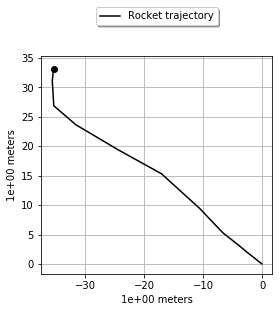

Starting to create LQR stabilization controller.
Finished creating LQR stabilization controller in 5.39 seconds.
Started simulation. Click `Stop Simulation` to stop.
Stopped simulation.
Initial state: [-39.69  44.87  -0.39   0.     0.     0.  ]
Goal state: [0 0 0 0 0 0]
Starting traj opt.
Finished traj opt in 0.28 seconds.


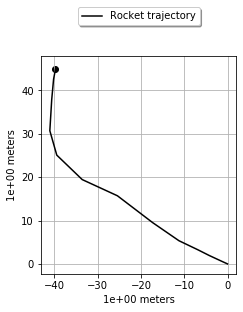

Starting to create LQR stabilization controller.
Finished creating LQR stabilization controller in 6.98 seconds.
Started simulation. Click `Stop Simulation` to stop.
Stopped simulation.
Initial state: [ 6.72 30.98 -0.14  0.    0.    0.  ]
Goal state: [0 0 0 0 0 0]
Starting traj opt.
Finished traj opt in 0.20 seconds.


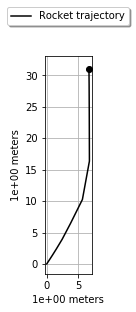

Starting to create LQR stabilization controller.
Finished creating LQR stabilization controller in 5.10 seconds.
Started simulation. Click `Stop Simulation` to stop.
Stopped simulation.


In [9]:
rocket_urdf = mk_rocket_urdf()

# visualize_urdf(rocket_urdf)

for i in range(3):
    simulate(rocket_urdf, rate=0.5, timeout=10)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ff9fee45-5c29-4deb-b21f-05d37017c5a6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>